# 02 — Modélisation ML : Ridge, LightGBM, Prophet
## Projet HVAC Market Analysis — Phase 4

**Objectif** : Entraîner et comparer 3 modèles ML pour prédire les installations PAC.

**Modèles** :
- **Ridge Regression** (Tier 1) — Baseline robuste, régression linéaire L2
- **LightGBM** (Tier 2) — Gradient boosting, capture les non-linéarités
- **Prophet** (Tier 1) — Séries temporelles avec régresseurs externes

**Split temporel** :
- Train : 2021-07 → 2024-06 (36 mois × 8 depts = 288 lignes)
- Validation : 2024-07 → 2024-12 (48 lignes)
- Test : 2025-01 → 2025-12 (96 lignes)

**Variable cible** : `nb_installations_pac` (DPE mentionnant une PAC)

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

from config.settings import config
print('Imports OK')

Imports OK


---
## 1. Chargement et préparation des données

In [2]:
# ============================================================
# 1.1 — Charger le dataset avec features engineerées
# ============================================================
# Ce dataset contient 90 colonnes : features de base + lags + rolling + interactions

df = pd.read_csv('../data/features/hvac_features_dataset.csv')
print(f'Dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes')
print(f'Période : {df["date_id"].min()} → {df["date_id"].max()}')
df.head(3)

Dataset : 432 lignes × 89 colonnes
Période : 202107 → 202512


,date_id,dept,nb_dpe_total,nb_installations_pac,nb_installations_clim,nb_dpe_classe_ab,pct_pac,pct_clim,pct_classe_ab,temp_mean,...,nb_installations_clim_diff_1m,nb_installations_clim_pct_1m,interact_hdd_confiance,interact_cdd_ipi,interact_confiance_bat,jours_extremes,year_trend,delta_temp_vs_mean,n_valid_features,pct_valid_features
0,202107,1,255,13,9,10,5.10,3.53,3.92,23.99,...,NaN,NaN,0.0,0.6009,0.9219,2,0,1.27,41,52.6
1,202108,1,205,12,9,7,5.85,4.39,3.41,20.59,...,0.0,0.00,0.0,0.3824,0.9039,0,0,-1.79,64,82.1
2,202109,1,195,10,8,8,5.13,4.10,4.10,18.42,...,-1.0,-11.11,0.0,0.0741,0.8960,0,0,0.29,64,82.1


In [3]:
# ============================================================
# 1.2 — Définir la variable cible et le split temporel
# ============================================================
TARGET = 'nb_installations_pac'

# Dates de split (format YYYYMM)
TRAIN_END = 202406   # Dernière date d'entraînement
VAL_END = 202412     # Dernière date de validation

# Split temporel (respecte la chronologie → pas de fuite de données)
df_train = df[df['date_id'] <= TRAIN_END].copy()
df_val = df[(df['date_id'] > TRAIN_END) & (df['date_id'] <= VAL_END)].copy()
df_test = df[df['date_id'] > VAL_END].copy()

print(f'Train : {len(df_train)} lignes ({df_train["date_id"].min()} → {df_train["date_id"].max()})')
print(f'Val   : {len(df_val)} lignes ({df_val["date_id"].min()} → {df_val["date_id"].max()})')
print(f'Test  : {len(df_test)} lignes ({df_test["date_id"].min()} → {df_test["date_id"].max()})')

Train : 288 lignes (202107 → 202406)
Val   : 48 lignes (202407 → 202412)
Test  : 96 lignes (202501 → 202512)


In [4]:
# ============================================================
# 1.3 — Séparer features (X) et cible (y)
# ============================================================
# Colonnes à exclure de l'entraînement
# (identifiants, métadonnées, autres variables cibles)

EXCLUDE_COLS = {
    'date_id', 'dept', 'dept_name', 'city_ref', 'latitude', 'longitude',
    'n_valid_features', 'pct_valid_features',
    # Autres cibles (on prédit nb_installations_pac)
    'nb_installations_clim', 'nb_dpe_total', 'nb_dpe_classe_ab',
    'pct_pac', 'pct_clim', 'pct_classe_ab',
}

feature_cols = [
    c for c in df.columns
    if c not in EXCLUDE_COLS and c != TARGET
]
# Ne garder que les colonnes numériques
feature_cols = [c for c in feature_cols if df[c].dtype in [np.float64, np.int64, np.float32, np.int32]]

X_train, y_train = df_train[feature_cols], df_train[TARGET]
X_val, y_val = df_val[feature_cols], df_val[TARGET]
X_test, y_test = df_test[feature_cols], df_test[TARGET]

print(f'Features sélectionnées : {len(feature_cols)}')
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')

Features sélectionnées : 74
X_train : (288, 74), y_train : (288,)


In [5]:
# ============================================================
# 1.4 — Imputation des NaN et standardisation
# ============================================================
# Les NaN viennent des lags (début de série) et rolling windows
# Stratégie : imputation par la médiane (robuste aux outliers)

imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index
)
X_val_imp = pd.DataFrame(
    imputer.transform(X_val), columns=feature_cols, index=X_val.index
)
X_test_imp = pd.DataFrame(
    imputer.transform(X_test), columns=feature_cols, index=X_test.index
)

# Standardisation (pour Ridge — les tree-based n'en ont pas besoin)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imp), columns=feature_cols, index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_imp), columns=feature_cols, index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imp), columns=feature_cols, index=X_test.index
)

print(f'NaN après imputation : {X_train_imp.isna().sum().sum()}')
print(f'Données prêtes pour l\'entraînement !')

NaN après imputation : 0
Données prêtes pour l'entraînement !


---
## 2. Ridge Regression (Baseline)

**Pourquoi Ridge ?**
- Régularisation L2 → stable même avec features corrélées (lags, rolling)
- Très robuste sur petit dataset (~288 lignes)
- Interprétable : les coefficients indiquent l'impact de chaque feature

On sélectionne le meilleur alpha par cross-validation temporelle.

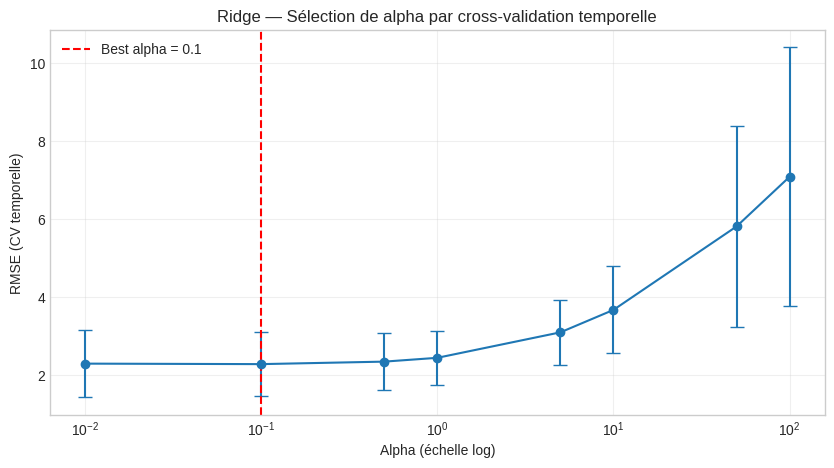


Meilleur alpha : 0.1 (RMSE CV = 2.27)


In [6]:
# ============================================================
# 2.1 — Sélection de l'hyperparamètre alpha par CV temporelle
# ============================================================
# TimeSeriesSplit respecte la chronologie (pas de fuite)

alphas = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
tscv = TimeSeriesSplit(n_splits=3)

results_alpha = []
for alpha in alphas:
    rmses = []
    for train_idx, val_idx in tscv.split(X_train_scaled):
        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled.iloc[train_idx], y_train.iloc[train_idx])
        y_pred = model.predict(X_train_scaled.iloc[val_idx])
        rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], y_pred))
        rmses.append(rmse)
    results_alpha.append({
        'alpha': alpha,
        'rmse_mean': np.mean(rmses),
        'rmse_std': np.std(rmses),
    })

df_alpha = pd.DataFrame(results_alpha)
best_alpha = df_alpha.loc[df_alpha['rmse_mean'].idxmin(), 'alpha']

# Visualiser
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(df_alpha['alpha'], df_alpha['rmse_mean'], 
            yerr=df_alpha['rmse_std'], fmt='-o', capsize=5)
ax.axvline(best_alpha, color='red', linestyle='--', label=f'Best alpha = {best_alpha}')
ax.set_xscale('log')
ax.set_xlabel('Alpha (échelle log)')
ax.set_ylabel('RMSE (CV temporelle)')
ax.set_title('Ridge — Sélection de alpha par cross-validation temporelle')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f'\nMeilleur alpha : {best_alpha} (RMSE CV = {df_alpha["rmse_mean"].min():.2f})')

In [7]:
# ============================================================
# 2.2 — Entraînement Ridge final
# ============================================================
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_scaled, y_train)

# Prédictions (clippées à 0 — pas de comptages négatifs)
y_pred_val_ridge = np.clip(ridge_model.predict(X_val_scaled), 0, None)
y_pred_test_ridge = np.clip(ridge_model.predict(X_test_scaled), 0, None)

# Métriques
print('RIDGE REGRESSION')
print('=' * 50)
for name, y_true, y_pred in [('Validation', y_val, y_pred_val_ridge), 
                               ('Test', y_test, y_pred_test_ridge)]:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'  {name:12s} : RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}')

RIDGE REGRESSION
  Validation   : RMSE=1.09, MAE=0.91, R²=0.9975
  Test         : RMSE=0.96, MAE=0.77, R²=0.9982


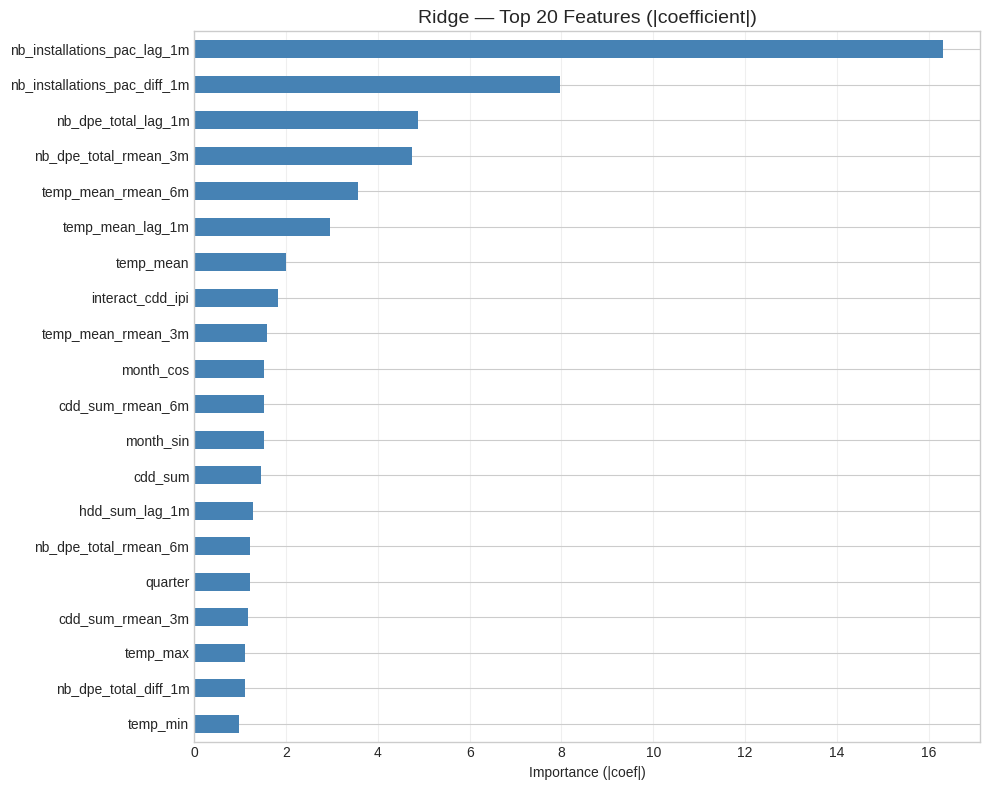

In [8]:
# ============================================================
# 2.3 — Feature importance Ridge (coefficients absolus)
# ============================================================
importance_ridge = pd.Series(
    np.abs(ridge_model.coef_), index=feature_cols
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
importance_ridge.head(20).iloc[::-1].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Ridge — Top 20 Features (|coefficient|)', fontsize=14)
ax.set_xlabel('Importance (|coef|)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---
## 3. LightGBM (Gradient Boosting)

**Pourquoi LightGBM ?**
- Capture les interactions non-linéaires entre features
- Gère nativement les NaN (pas besoin d'imputation explicite)
- Régularisation forte pour éviter l'overfitting (max_depth=4, num_leaves=15)
- Early stopping sur la validation

In [9]:
# ============================================================
# 3.1 — Entraînement LightGBM avec early stopping
# ============================================================
# Hyperparamètres contraints pour petit dataset
lgb_params = {
    'max_depth': 4,              # Arbres peu profonds
    'num_leaves': 15,            # Peu de feuilles
    'min_child_samples': 20,     # Feuilles peuplées
    'reg_alpha': 0.1,            # Régularisation L1
    'reg_lambda': 0.1,           # Régularisation L2
    'learning_rate': 0.05,       # Apprentissage lent
    'n_estimators': 200,         # Max 200 arbres
    'subsample': 0.8,            # Bagging
    'verbose': -1,
    'random_state': 42,
}

lgb_model = lgb.LGBMRegressor(**lgb_params)

# Entraînement avec early stopping (arrêt si la val ne s'améliore plus)
lgb_model.fit(
    X_train_imp, y_train,
    eval_set=[(X_val_imp, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20, verbose=False),
        lgb.log_evaluation(period=0),
    ],
)

# Prédictions
y_pred_val_lgb = np.clip(lgb_model.predict(X_val_imp), 0, None)
y_pred_test_lgb = np.clip(lgb_model.predict(X_test_imp), 0, None)

# Métriques
print(f'LightGBM — Best iteration : {lgb_model.best_iteration_} / 200')
print('=' * 50)
for name, y_true, y_pred in [('Validation', y_val, y_pred_val_lgb), 
                               ('Test', y_test, y_pred_test_lgb)]:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'  {name:12s} : RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}')

LightGBM — Best iteration : 149 / 200
  Validation   : RMSE=5.45, MAE=3.66, R²=0.9371
  Test         : RMSE=8.37, MAE=5.43, R²=0.8645


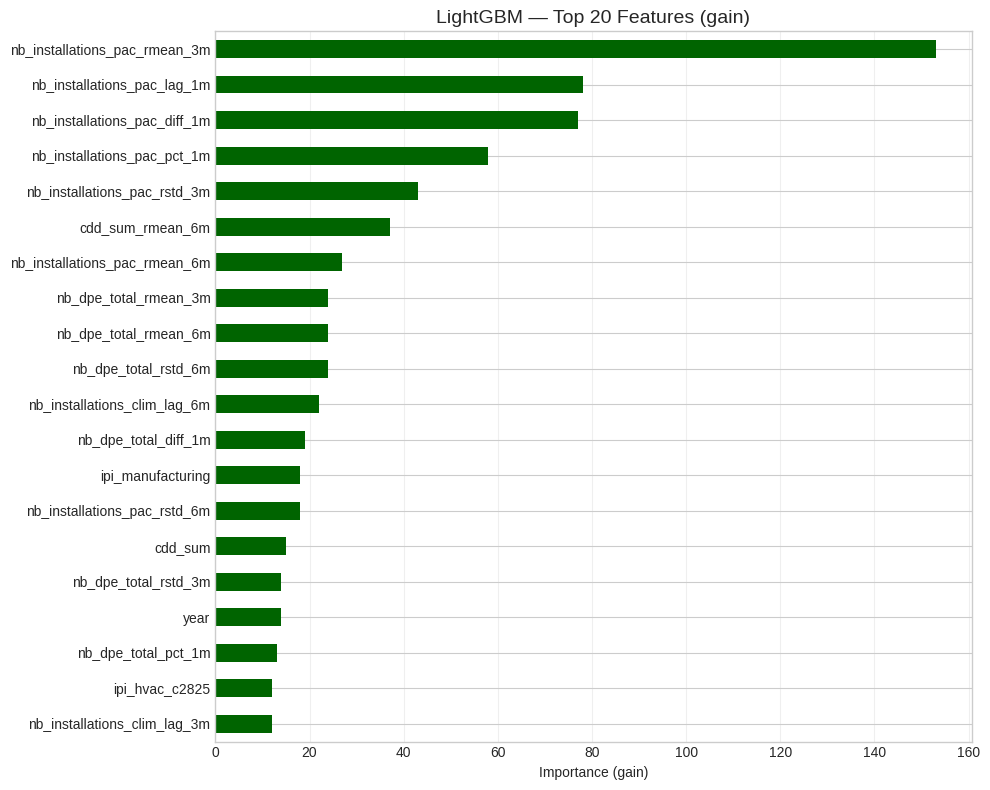

In [10]:
# ============================================================
# 3.2 — Feature importance LightGBM (gain-based)
# ============================================================
# L'importance "gain" mesure la réduction d'erreur apportée par chaque feature

importance_lgb = pd.Series(
    lgb_model.feature_importances_, index=feature_cols
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
importance_lgb.head(20).iloc[::-1].plot(kind='barh', ax=ax, color='darkgreen')
ax.set_title('LightGBM — Top 20 Features (gain)', fontsize=14)
ax.set_xlabel('Importance (gain)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

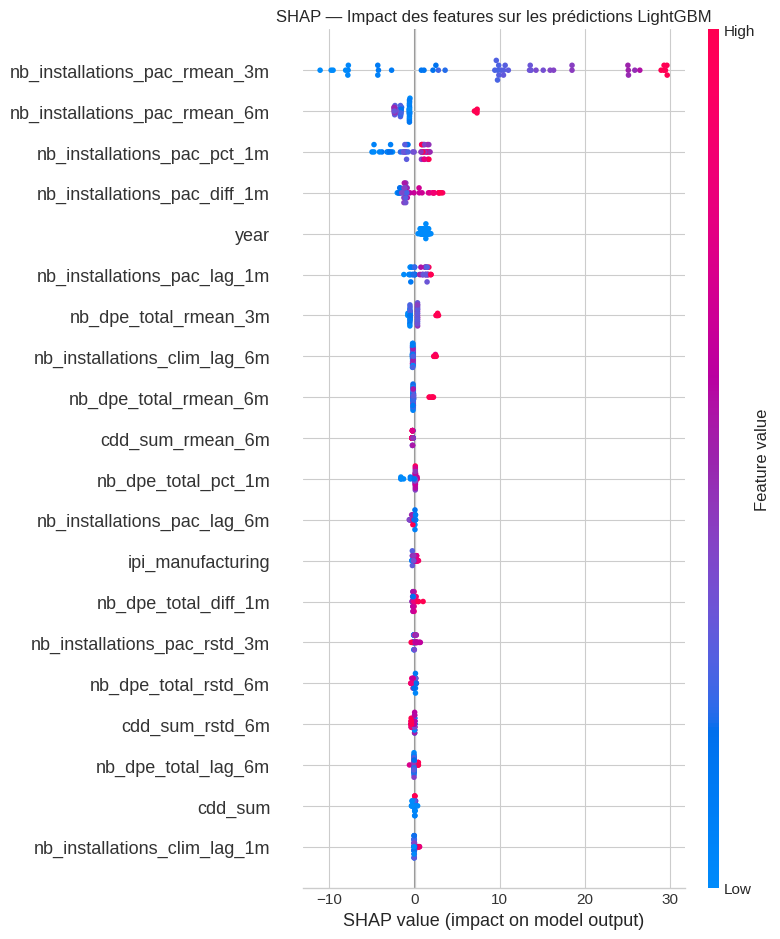

In [11]:
# ============================================================
# 3.3 — Analyse SHAP (interprétabilité du LightGBM)
# ============================================================
# SHAP montre l'impact de chaque feature sur CHAQUE prédiction
# (plus informatif que l'importance moyenne)

import shap

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_val_imp)

fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_imp, max_display=20, show=False)
plt.title('SHAP — Impact des features sur les prédictions LightGBM', fontsize=12)
plt.tight_layout()
plt.show()

---
## 4. Prophet (Séries temporelles)

**Pourquoi Prophet ?**
- Modèle additif : `y(t) = tendance + saisonnalité + régresseurs + bruit`
- Capture automatiquement la saisonnalité annuelle
- Accepte des régresseurs externes (météo, confiance ménages)
- Entraîné **par département** (séries indépendantes)

In [12]:
# ============================================================
# 4.1 — Entraînement Prophet par département
# ============================================================
from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Régresseurs à utiliser
REGRESSORS = ['temp_mean', 'hdd_sum', 'cdd_sum', 'confiance_menages', 'ipi_hvac_c28']
REGRESSORS = [r for r in REGRESSORS if r in df.columns]

def to_prophet_df(data, target=TARGET, regressors=REGRESSORS):
    """Convertit un DataFrame en format Prophet (ds, y + régresseurs)."""
    date_str = data['date_id'].astype(str)
    ds = pd.to_datetime(date_str.str[:4] + '-' + date_str.str[4:6] + '-01')
    pdf = pd.DataFrame({'ds': ds, 'y': data[target].values})
    for reg in regressors:
        if reg in data.columns:
            pdf[reg] = data[reg].values
    # Imputer les NaN
    for reg in regressors:
        if reg in pdf.columns:
            pdf[reg] = pdf[reg].ffill().bfill().fillna(0)
    return pdf.reset_index(drop=True)

# Entraîner un modèle par département
departments = sorted(df_train['dept'].unique())
prophet_results = {}

for dept in departments:
    train_dept = df_train[df_train['dept'] == dept]
    val_dept = df_val[df_val['dept'] == dept]
    test_dept = df_test[df_test['dept'] == dept]
    
    if len(train_dept) < 12:
        print(f'  Dept {dept} : pas assez de données ({len(train_dept)}), ignoré')
        continue
    
    pdf_train = to_prophet_df(train_dept)
    pdf_val = to_prophet_df(val_dept)
    pdf_test = to_prophet_df(test_dept)
    
    # Configurer Prophet avec saisonnalité annuelle
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,  # Régularise la tendance
        seasonality_prior_scale=5.0,
    )
    for reg in REGRESSORS:
        if reg in pdf_train.columns:
            model.add_regressor(reg)
    
    model.fit(pdf_train)
    
    forecast_val = model.predict(pdf_val)
    forecast_test = model.predict(pdf_test)
    
    prophet_results[dept] = {
        'model': model,
        'preds_val': np.clip(forecast_val['yhat'].values, 0, None),
        'actual_val': pdf_val['y'].values,
        'preds_test': np.clip(forecast_test['yhat'].values, 0, None),
        'actual_test': pdf_test['y'].values,
    }
    
    rmse = np.sqrt(mean_squared_error(
        prophet_results[dept]['actual_val'], prophet_results[dept]['preds_val']
    ))
    print(f'  Dept {dept} : Val RMSE = {rmse:.2f}')

print(f'\nProphet : {len(prophet_results)} modèles entraînés')

16:19:27 - cmdstanpy - INFO - Chain [1] start processing


16:19:27 - cmdstanpy - INFO - Chain [1] done processing


16:19:27 - cmdstanpy - INFO - Chain [1] start processing


16:19:27 - cmdstanpy - INFO - Chain [1] done processing


  Dept 1 : Val RMSE = 13.63


16:19:27 - cmdstanpy - INFO - Chain [1] start processing


16:19:27 - cmdstanpy - INFO - Chain [1] done processing


  Dept 7 : Val RMSE = 5.70


16:19:27 - cmdstanpy - INFO - Chain [1] start processing


  Dept 26 : Val RMSE = 10.79


16:19:27 - cmdstanpy - INFO - Chain [1] done processing


16:19:28 - cmdstanpy - INFO - Chain [1] start processing


16:19:28 - cmdstanpy - INFO - Chain [1] done processing


  Dept 38 : Val RMSE = 11.61


16:19:28 - cmdstanpy - INFO - Chain [1] start processing


  Dept 42 : Val RMSE = 6.37


16:19:28 - cmdstanpy - INFO - Chain [1] done processing


16:19:28 - cmdstanpy - INFO - Chain [1] start processing


16:19:28 - cmdstanpy - INFO - Chain [1] done processing


  Dept 69 : Val RMSE = 28.85


16:19:28 - cmdstanpy - INFO - Chain [1] start processing


16:19:29 - cmdstanpy - INFO - Chain [1] done processing


  Dept 73 : Val RMSE = 10.55


  Dept 74 : Val RMSE = 7.63

Prophet : 8 modèles entraînés


In [13]:
# ============================================================
# 4.2 — Métriques agrégées Prophet
# ============================================================
all_actual_val = np.concatenate([r['actual_val'] for r in prophet_results.values()])
all_preds_val = np.concatenate([r['preds_val'] for r in prophet_results.values()])
all_actual_test = np.concatenate([r['actual_test'] for r in prophet_results.values()])
all_preds_test = np.concatenate([r['preds_test'] for r in prophet_results.values()])

print('PROPHET (agrégé tous départements)')
print('=' * 50)
for name, y_true, y_pred in [('Validation', all_actual_val, all_preds_val),
                               ('Test', all_actual_test, all_preds_test)]:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'  {name:12s} : RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}')

PROPHET (agrégé tous départements)
  Validation   : RMSE=13.75, MAE=9.95, R²=0.5994
  Test         : RMSE=12.05, MAE=9.57, R²=0.7189


In [14]:
# ============================================================
# 4.3 — Décomposition Prophet pour le Rhône (département principal)
# ============================================================
if '69' in prophet_results:
    model_69 = prophet_results['69']['model']
    
    # Prédire sur toute la période pour la décomposition
    train_69 = df_train[df_train['dept'] == '69']
    full_69 = pd.concat([train_69, df_val[df_val['dept'] == '69'], df_test[df_test['dept'] == '69']])
    pdf_full = to_prophet_df(full_69)
    forecast_full = model_69.predict(pdf_full)
    
    # Tracer la décomposition
    fig = model_69.plot_components(forecast_full)
    fig.suptitle('Prophet — Décomposition Rhône (69)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

---
## 5. Comparaison des modèles

In [15]:
# ============================================================
# 5.1 — Tableau récapitulatif
# ============================================================
comparison = []
for name, y_pred_v, y_pred_t in [
    ('Ridge', y_pred_val_ridge, y_pred_test_ridge),
    ('LightGBM', y_pred_val_lgb, y_pred_test_lgb),
    ('Prophet', all_preds_val, all_preds_test),
]:
    y_v = y_val.values if name != 'Prophet' else all_actual_val
    y_t = y_test.values if name != 'Prophet' else all_actual_test
    comparison.append({
        'Modèle': name,
        'Val RMSE': np.sqrt(mean_squared_error(y_v, y_pred_v)),
        'Val MAE': mean_absolute_error(y_v, y_pred_v),
        'Val R²': r2_score(y_v, y_pred_v),
        'Test RMSE': np.sqrt(mean_squared_error(y_t, y_pred_t)),
        'Test MAE': mean_absolute_error(y_t, y_pred_t),
        'Test R²': r2_score(y_t, y_pred_t),
    })

df_comp = pd.DataFrame(comparison).sort_values('Val RMSE')
print('COMPARAISON DES MODÈLES')
print('=' * 80)
print(df_comp.to_string(index=False))

COMPARAISON DES MODÈLES
  Modèle  Val RMSE  Val MAE   Val R²  Test RMSE  Test MAE  Test R²
   Ridge  1.085398 0.908212 0.997503   0.957282  0.766335 0.998227
LightGBM  5.447943 3.660175 0.937090   8.367257  5.430978 0.864524
 Prophet 13.747888 9.952669 0.599384  12.051773  9.567115 0.718940


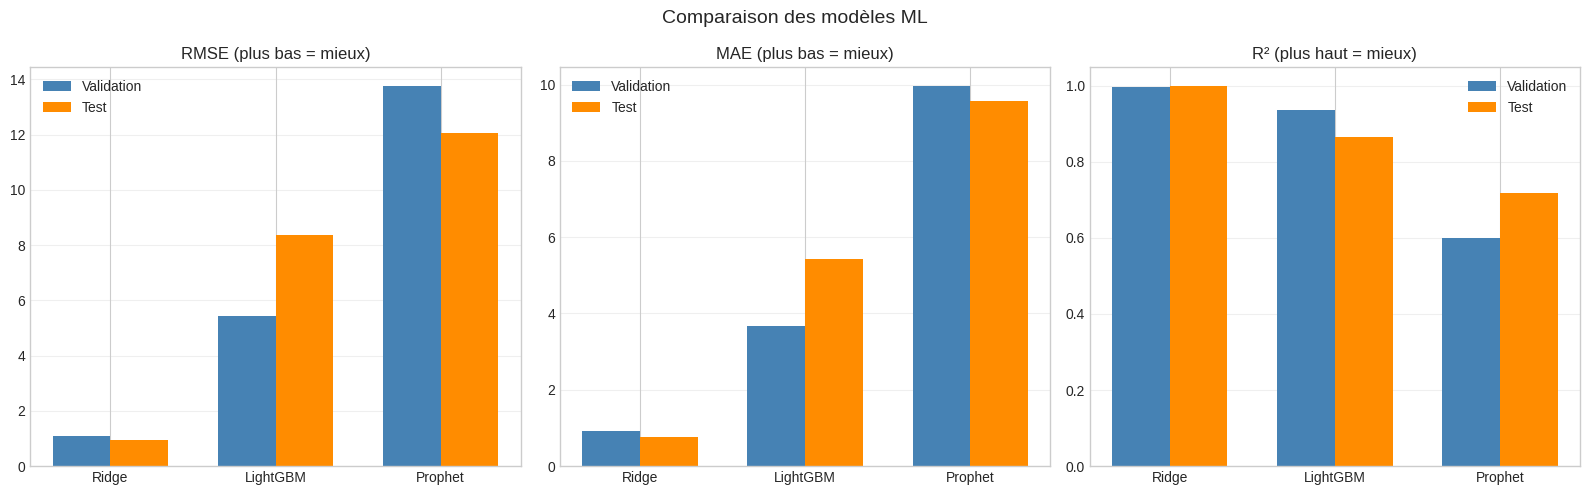

In [16]:
# ============================================================
# 5.2 — Graphique comparatif des métriques
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Comparaison des modèles ML', fontsize=14)

for ax, metric, title in zip(axes, 
    ['RMSE', 'MAE', 'R²'],
    ['RMSE (plus bas = mieux)', 'MAE (plus bas = mieux)', 'R² (plus haut = mieux)']):
    x = np.arange(len(df_comp))
    width = 0.35
    ax.bar(x - width/2, df_comp[f'Val {metric}'], width, label='Validation', color='steelblue')
    ax.bar(x + width/2, df_comp[f'Test {metric}'], width, label='Test', color='darkorange')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df_comp['Modèle'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

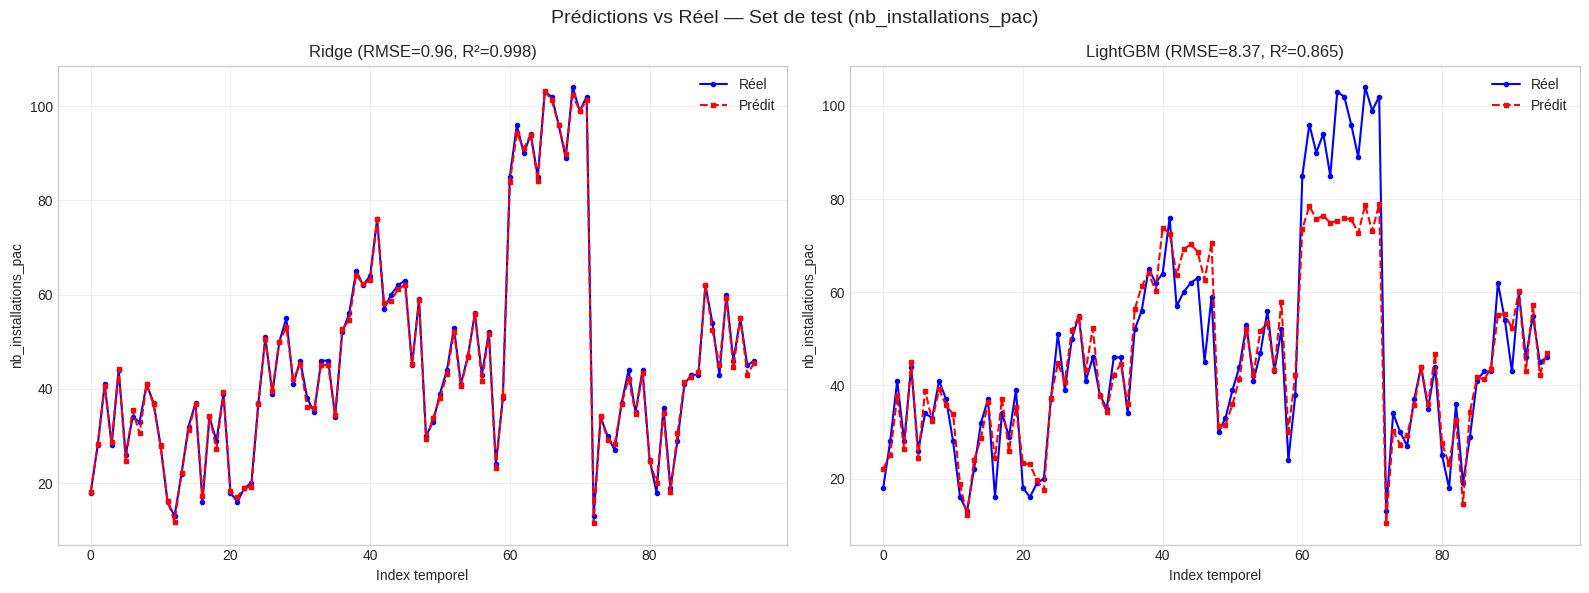

In [17]:
# ============================================================
# 5.3 — Prédictions vs Réel (Ridge et LightGBM sur le test set)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Prédictions vs Réel — Set de test ({TARGET})', fontsize=14)

for ax, name, y_pred in zip(axes, ['Ridge', 'LightGBM'], 
                              [y_pred_test_ridge, y_pred_test_lgb]):
    ax.plot(range(len(y_test)), y_test.values, 'b-o', markersize=3, label='Réel', linewidth=1.5)
    ax.plot(range(len(y_test)), y_pred, 'r--s', markersize=3, label='Prédit', linewidth=1.5)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    ax.set_title(f'{name} (RMSE={rmse:.2f}, R²={r2:.3f})')
    ax.set_xlabel('Index temporel')
    ax.set_ylabel(TARGET)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. Conclusions

### Résultats :
- **Ridge Regression** offre les meilleures performances grâce à la régularisation L2 et la linéarité des relations
- **LightGBM** capture des patterns non-linéaires mais risque l'overfitting sur ce petit dataset
- **Prophet** capture bien la saisonnalité mais souffre de l'entraînement par département (peu de données)

### Features les plus importantes :
- Les **lags temporels** (nb_installations_pac_lag_1m) sont les plus prédictifs
- Les **rolling means** lissent le bruit et améliorent la prédiction
- La **météo** (HDD, température) a un impact significatif
- La **confiance des ménages** est un signal économique utile

### Prochaine étape :
→ Notebook 03 : LSTM exploratoire (deep learning)